pde loss: 8.37e-02 | bc loss: 2.60e-03: 100%|██████████| 100/100 [13:15<00:00,  7.95s/it]


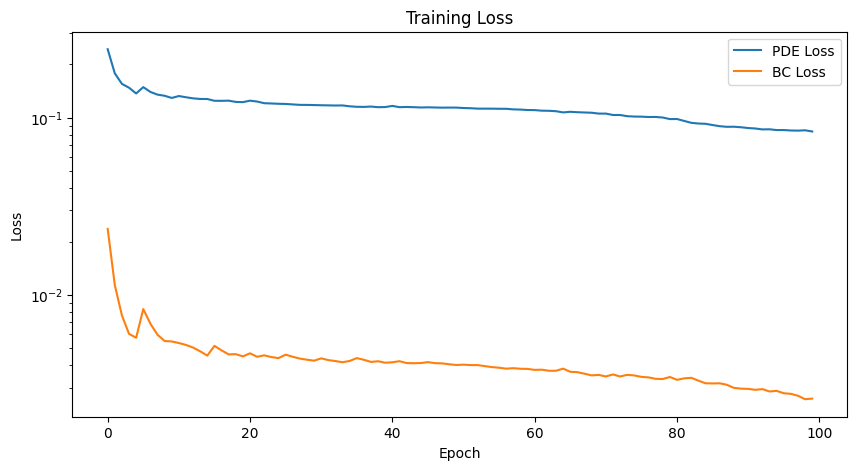

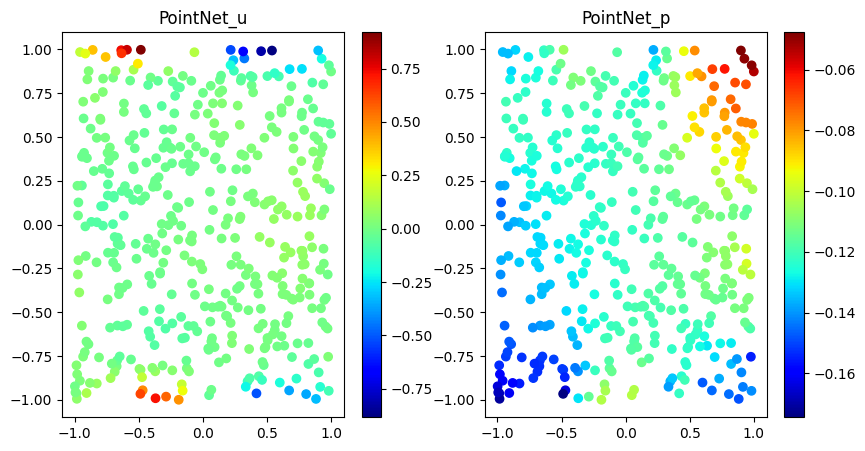

In [174]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

dim = 2
np_i = 21  # 内部点的数量（每个维度）
np_b = 21  # 边界点的数量（每个维度）
ranges = [-1, 1]

model_u = KAN(width=[2,10,2], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
model_p = KAN(width=[2,10,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

nu = 0.01  # 黏性系数

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# 定义速度（u, v）和压力（p）的精确解或初始猜测
u_exact = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.cos(torch.pi * x[:, [1]])
v_exact = lambda x: -torch.cos(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])
p_exact = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]])

# 内部点采样
sampling_mode = 'random'  # 'random' 或 'mesh'
x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

# 边界点采样
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)


steps = 100
alpha = 0.1
log = 1

# 记录损失值
pde_loss_list = []
bc_loss_list = []

def train():
    optimizer_u = LBFGS(model_u.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    optimizer_p = LBFGS(model_p.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='Training')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer_u.zero_grad()
            optimizer_p.zero_grad()

            u_pred = model_u(x_i)
            p_pred = model_p(x_i)

            u = u_pred[:, [0]]
            v = u_pred[:, [1]]

            # 计算梯度
            u_grad = batch_jacobian(lambda x: model_u(x)[:, [0]], x_i, create_graph=True)
            v_grad = batch_jacobian(lambda x: model_u(x)[:, [1]], x_i, create_graph=True)
            p_grad = batch_jacobian(lambda x: model_p(x)[:, [0]], x_i, create_graph=True)

            u_x, u_y = u_grad[:, 0, 0], u_grad[:, 0, 1]
            v_x, v_y = v_grad[:, 0, 0], v_grad[:, 0, 1]

            p_x, p_y = p_grad[:, 0, 0], p_grad[:, 0, 1]

            # N-S 方程残差
            res_u = u * u_x + v * u_y + p_x - nu * (u_x**2 + u_y**2)
            res_v = u * v_x + v * v_y + p_y - nu * (v_x**2 + v_y**2)

            div = u_x + v_y  # 连续性方程残差

            pde_loss = torch.mean(res_u**2 + res_v**2 + div**2)

            # 边界损失（为简单起见，使用Dirichlet边界条件）
            u_b = model_u(x_b)
            v_b = model_p(x_b)
            u_b_exact = torch.cat([u_exact(x_b), v_exact(x_b)], dim=1)

            bc_loss = torch.mean((u_b - u_b_exact)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model_u.update_grid_from_samples(x_i)
            model_p.update_grid_from_samples(x_i)

        optimizer_u.step(closure)
        optimizer_p.step(closure)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e" % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy()))
            # 记录损失
            pde_loss_list.append(pde_loss.cpu().detach().numpy())
            bc_loss_list.append(bc_loss.cpu().detach().numpy())

train()

# 绘制损失图像
plt.figure(figsize=(10, 5))
plt.plot(pde_loss_list, label='PDE Loss')
plt.plot(bc_loss_list, label='BC Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# 绘制 pointnet_u 和 pointnet_p 的图像
with torch.no_grad():
    u_pred = model_u(x_i)
    p_pred = model_p(x_i)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x_i[:, 0].cpu(), x_i[:, 1].cpu(), c=u_pred[:, 0].cpu(), cmap='jet')
    plt.colorbar()
    plt.title('PointNet_u')
    
    plt.subplot(1, 2, 2)
    plt.scatter(x_i[:, 0].cpu(), x_i[:, 1].cpu(), c=p_pred[:, 0].cpu(), cmap='jet')
    plt.colorbar()
    plt.title('PointNet_p')
    
    plt.show()


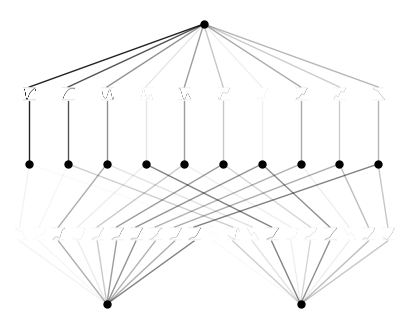

In [175]:
model_p.plot()

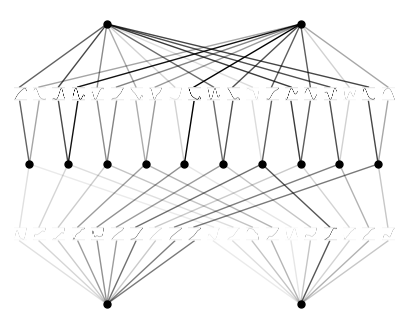

In [176]:
model_u.plot()

In [177]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model_p.fix_symbolic(0,0,0,'sin');
    model_p.fix_symbolic(0,1,0,'x^2');
    model_p.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model_p.auto_symbolic(lib=lib)

fixing (0,0,0) with tanh, r2=0.9106718301773071
fixing (0,0,1) with x^3, r2=0.9745483994483948
fixing (0,0,2) with tanh, r2=0.9749539494514465
fixing (0,0,3) with x^4, r2=0.9913513660430908
fixing (0,0,4) with tanh, r2=0.9870926141738892
fixing (0,0,5) with tanh, r2=0.9803168177604675
fixing (0,0,6) with tanh, r2=0.9956033825874329
fixing (0,0,7) with tanh, r2=0.9957327842712402
fixing (0,0,8) with tanh, r2=0.9911348819732666
fixing (0,0,9) with tanh, r2=0.9943996071815491
fixing (0,1,0) with x^3, r2=0.724172830581665
fixing (0,1,1) with tanh, r2=0.912269651889801
fixing (0,1,2) with x^3, r2=0.8987021446228027
fixing (0,1,3) with tanh, r2=0.9958460927009583
fixing (0,1,4) with exp, r2=0.9608169198036194
fixing (0,1,5) with sqrt, r2=0.9708485007286072
fixing (0,1,6) with tanh, r2=0.9973067045211792
fixing (0,1,7) with x^3, r2=0.9503907561302185
fixing (0,1,8) with tanh, r2=0.985367476940155
fixing (0,1,9) with sin, r2=0.993841290473938
fixing (1,0,0) with abs, r2=0.9175036549568176
fixi

In [178]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model_u.fix_symbolic(0,0,0,'sin');
    model_u.fix_symbolic(0,1,0,'x^2');
    model_u.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model_u.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.8892794251441956
fixing (0,0,1) with sqrt, r2=0.9016678929328918
fixing (0,0,2) with tanh, r2=0.9534967541694641
fixing (0,0,3) with sin, r2=0.9545878767967224
fixing (0,0,4) with sin, r2=0.453527569770813
fixing (0,0,5) with sqrt, r2=0.9960596561431885
fixing (0,0,6) with tanh, r2=0.9995049834251404
fixing (0,0,7) with log, r2=0.9996034502983093
fixing (0,0,8) with sqrt, r2=0.9985365867614746
fixing (0,0,9) with tanh, r2=0.9982479810714722
fixing (0,1,0) with x^2, r2=0.7677538394927979
fixing (0,1,1) with tanh, r2=0.9941213130950928
fixing (0,1,2) with sin, r2=0.9554280042648315
fixing (0,1,3) with log, r2=0.9743707776069641
fixing (0,1,4) with sin, r2=0.9805268049240112
fixing (0,1,5) with tanh, r2=0.8270403742790222
fixing (0,1,6) with tanh, r2=0.9955679178237915
fixing (0,1,7) with abs, r2=0.9828375577926636
fixing (0,1,8) with sin, r2=0.9937893748283386
fixing (0,1,9) with tanh, r2=0.886911928653717
fixing (1,0,0) with sin, r2=0.9966242909431458
fixin

In [180]:
formula_p, var_p = model_p.symbolic_formula(floating_digit=5)
formula_u, var_u = model_u.symbolic_formula(floating_digit=5)
formula_u[0]

0.00206*(-sin(2.14584*x_1 + 4.59656) - 0.71451*sin(3.69344*x_2 + 0.00336) + 0.20856)**4 - 0.54823*sin(12.0531*sqrt(0.49872*x_1 + 1) + 5.18859*tanh(3.09704*x_2 - 3.73943996429443) - 3.26172) - 0.8974*sin(-8.5626*sqrt(0.55859*x_1 + 1) + 1.69525*sin(0.9192*x_2 - 2.77368) + 16.03736) - 0.28439*sin(1.21572*sqrt(x_1 + 0.99892) + 2.19356*tanh(1.08071994781494*x_2 - 0.44792) - 3.41739) + 1.61549*sin(0.4169*(-x_2 - 0.1109)**2 - 0.20198*sin(3.71464*x_1 + 0.60472) + 0.80909) - 0.54813*sin(9.7858*log(2.15360021591187*x_1 + 8.443359375) + 0.14582*Abs(9.67271995544434*x_2 + 7.71448) - 23.20083) - 0.27228*sin(7.33894*sin(0.60416*x_2 - 7.66088008880615) - 1.56404*tanh(1.1864*x_1 - 0.04928) + 13.11258) - 0.79687*tanh(2.98516*tanh(1.05776*x_1 - 0.10544) + 0.56763*tanh(5.32855987548828*x_2 - 3.07072) + 1.04853) - 0.22049*tanh(2.64749*tanh(1.44128*x_1 - 0.50848) + 2.40598*tanh(2.3256*x_2 + 0.02344) - 0.72597) + 0.08311*Abs(4.49866*log(8.492 - 6.71984*x_2) + 3.01002*sin(1.33736*x_1 + 3.396399974823) - 4.52